In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform, choice, randint
from numpy import pi
import sys, shutil
from tqdm import tqdm
from deeptracktorch.disp import *
from deeptracktorch.simg import *
from deeptracktorch.fastai_adapter import *
from deeptracktorch.measures import radialcenter
from deeptracktorch.models import DeepTrackNet
from deeptracktorch.video import track_single_particle

from fastai.vision import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Demonstrating single particle position extraction performance
> An experiment to train DeepTrackTorch to extract position of a particle from image containing a single particle.

## Introduction

This notebook demonstrates the valid implementation of deeptrack in PyTorch by replicating the first set of experimental results given the [DeepTrack paper](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506). 

The first experiment compares the ability of the DeepTrack network to extract particle position from still images in comparison to existing particle detection techniques such as a radial symmetry method.

We test a number of the DeepTrack neural network that have been trained in different ways. These are explained in the relevant sections below.

## 1. Extracting the position of a single particle in still images.

In the [paper](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) the authors test the performance of DeepTrack on simulated images with a range of SNR values and homogeneous illumination (i.e., without any illumination gradient). 

They found that DeepTrack achieves subpixel accuracy over a range of SNRs (from SNR = 3.2 to 80). They benchmark DeepTrack against the centroid and radial symmetry algorithms (gray circles and squares respectively) by testing them on the same set of images.

Similarly they tested DeepTrack on one thousand images (with fixed SNR = 50) that were affected by a range of illumination gradients with random direction.

These are the original published results:

![Test image](images/E0_results.png)

### Training image set

Following from the [example notebook - 1a](https://github.com/softmatterlab/DeepTrack/blob/master/DeepTrack%201.0/DeepTrack%20-%20Example%201a%20-%20Tracking%20single%20particle.ipynb) the particle position is chosen randomly from a normal distribution with mean of 0 and standard deviation of 1 pixel. The particle has a radius between 1.5 and 3 pixels, and a point-spread function obtained from Bessel function of the first kind of first or second order with positive or negative intensity. The image background, SNR and gradient intensity are randomly selected from a wide range of values. There is one and only one particle per image in this test.

These parameters are expressed as follows:

In [ ]:
base_img_params = {   
       'n_particles': lambda n: np.ones(n),#randint(0,1, n),
    'size': lambda n: np.ones(n) * 51,
    'bkgd_level': lambda n: uniform(0.2,0.8,n),
    'gradient_intensity': lambda n: uniform(0,0.8,n),
    'gradient_direction': lambda n: uniform(-pi,pi,n),
    'snr': lambda n: uniform(5,100,n),
    
   
  }

base_particle_params = {
     # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda n: np.clip(normal(0., 0.03, n),-1.1,1.1),
    'y': lambda n: np.clip(normal(0., 0.03, n),-1.1,1.1),
    
    # I don't know what units this is in... pixels?
    'radius': lambda n: uniform(1.5, 3, n),
    'intensities': lambda n: [x for x in zip(uniform(.7, .9, n), -uniform(.2, .3, n))],
    'bessel_orders': lambda n: [(1, 2)] * n,
    'ellip_direction': lambda n: uniform(-pi, pi,n),
    'ellipticity':  lambda n: np.ones(n),
  }

The training of the network was carried out on a [colab](https://colab.research.google.com/drive/1EcLXHPFqn3l0vKiY2t9TvaTwFwB7ed6C) notebook but the following demonstrates sample training images.

[None, None, None, None, None]

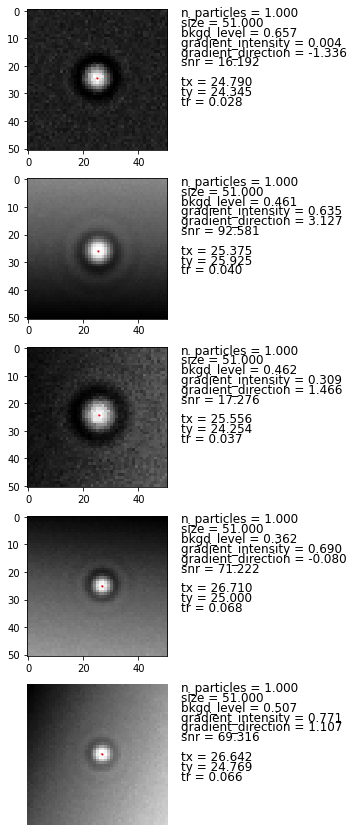

In [ ]:
train_specs_df = add_target(define_image(base_img_params, base_particle_params, N=5), mode='r')
f,ax=plt.subplots(5,1,figsize=(5,15))
[annotate_image(generate_image(i_s),i_s,ax=ax[i]) for (i,i_s) in train_specs_df.iterrows()]

This model was trained using 100k images generated using the above parameter distributions. (Note DeepTrack using 1.5 million training images)

Two variables that were explored were the spread of the position of the particle and the number of particles in the image. The DeepTrack paper [was not clear?] about the number of particles in the image. For additional experiments I wanted the network to perform with more than one particle in the image (in this case we want the network to predict the location of the most central particle) and images containing no particle. 

Secondly the were really close to the centre of the image, moving only by a few pixels from the image center. I wanted to understand the affects of allowing more variation in particle position in the training set.

The following table shows the combinations of training set images that were generated and used to train the network.

|Spread||Particles||
|-----|:-:|:-:|:----:|
| |__Exactly 1__|__0 or 1__|__0<=5__| 
|__Narrow__|X|X|X|
|__Wide__|X|X|X|

### Load Pre-trained model

In [ ]:
learner = load_learner('models/100k/r/1/close')

### Create test dataset

Create a dataset that we feed to the network to get it's inferences. Use the same parameters used to create the training images

In [ ]:
test_img_dist = base_img_params.copy()
test_p_dist = base_particle_params.copy()
test_img_dist['gradient_intensity']=lambda n: np.zeros(n)

test_p_dist

{'x': <function __main__.<lambda>(n)>,
 'y': <function __main__.<lambda>(n)>,
 'radius': <function __main__.<lambda>(n)>,
 'intensities': <function __main__.<lambda>(n)>,
 'bessel_orders': <function __main__.<lambda>(n)>,
 'ellip_direction': <function __main__.<lambda>(n)>,
 'ellipticity': <function __main__.<lambda>(n)>}

### Measure performance vs Radial Symmetry method for varying levels of SNR

Now loop through SNR values and evaluate predictions, record results

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


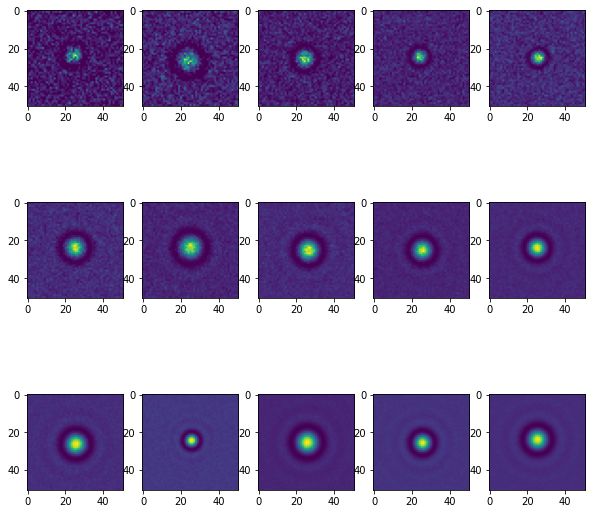

In [ ]:
#notest
MAE_snr_dtt=[]
MAE_snr_sym=[]

i=0
f,ax=plt.subplots(3,5,figsize=(10,10))
ax=ax.flatten()

for snr in tqdm(np.logspace(np.log10(3),np.log10(80), num=15)):
    # fix the snr
    test_img_dist['snr'] = lambda n: np.ones(n) * snr
    # produce 1000 images at this SNR
    test_df = add_target(define_image(test_img_dist, test_p_dist, N=10))
    #display(test_df)
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try deeptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    ax[i].imshow(test_images[0].px.squeeze())
    
    i+=1
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    MAE_snr_dtt += [[snr, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_snr_sym += [[snr, mean_absolute_error(test_truth, sym_preds)]]
    

import pickle
with open('snr_results.pkl','wb') as f:
    pickle.dump((MAE_snr_dtt,MAE_snr_sym),f)
   

In [ ]:
 mean_absolute_error(test_truth, sym_preds)

0.7897723349053228

In [ ]:
mean_absolute_error(test_truth, dtt_preds)


0.8515206262217987

0
24.447940988987053 26.030793212599985
24.447940988987053 26.030793212599985
1
24.583877583972136 25.160785968175684
24.583877583972136 25.160785968175684
2
24.4909164477719 23.498155944775142
24.4909164477719 23.498155944775142
3
23.927275756054737 25.8021755656604
23.927275756054737 25.8021755656604
4
24.914180310688774 25.570161526875072
24.914180310688774 25.570161526875072
5
24.879792216075163 25.1760880614853
24.879792216075163 25.1760880614853
6
24.758060098210507 24.239537777092494
24.758060098210507 24.239537777092494
7
25.259388648001355 25.344082811388994
25.259388648001355 25.344082811388994
8
24.04997538857453 24.74753441605783
24.04997538857453 24.74753441605783
9
24.88082142135333 25.409134009962802
24.88082142135333 25.409134009962802


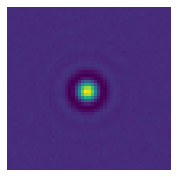

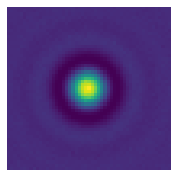

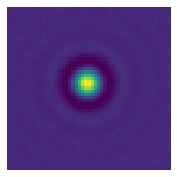

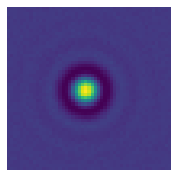

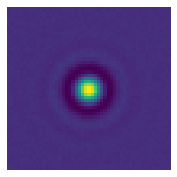

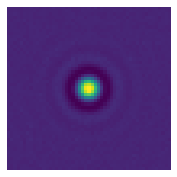

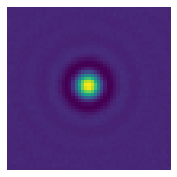

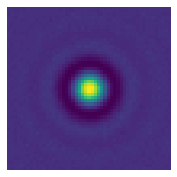

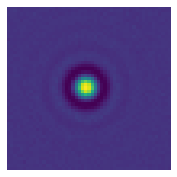

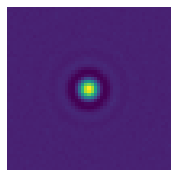

In [ ]:
for i in range(10):
    print(i)
    print(test_df.iloc[i]['particles'][0]['cx'],test_df.iloc[i]['particles'][0]['cy'])
    print(test_df.iloc[i]['tx'],test_df.iloc[i]['ty'])
    test_images[i].show()


### Performance for varying background gradient intensities

Set up experimental parameters

In [ ]:
test_img_dist = base_img_params
test_p_dist = base_particle_params

test_img_dist['snr'] = lambda: 50

Now loop through gradient intensity values and evaluate predictions, record results

In [ ]:
#notest
MAE_gi_dtt=[]
MAE_gi_sym=[]

for gi in np.linspace(0,1, num=11):
    # fix the gradient
    test_img_dist['gradient_intensity'] = lambda : gi
    
    # produce 1000 images at this SNR
    test_df = define_image(test_img_dist, test_p_dist, 100)
    test_df = add_target(test_df)
    
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    
    MAE_gi_dtt += [[gi, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_gi_sym += [[gi, mean_absolute_error(test_truth, sym_preds)]]



TypeError: <lambda>() takes 0 positional arguments but 1 was given

In [ ]:
import pickle
with open('gi_results.pkl','wb') as f:
    pickle.dump((MAE_gi_dtt,MAE_gi_sym),f)

### Plot results

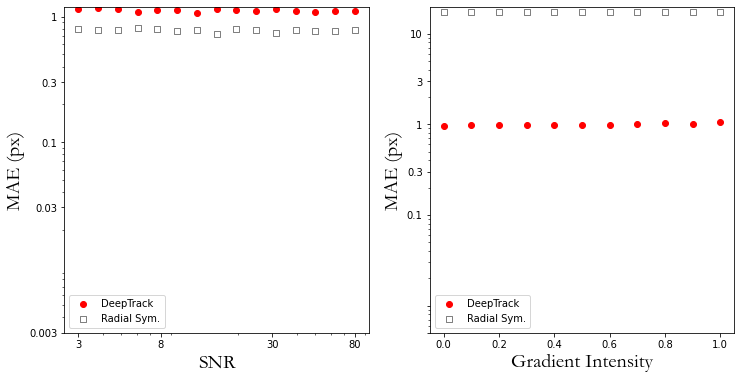

In [ ]:
#notest
#hide
with open('snr_results.pkl','rb') as f:
    Md_snr,Ms_snr = pickle.load(f)

with open('gi_results.pkl','rb') as f:
    Md_gi,Ms_gi = pickle.load(f)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x=np.array(Md_snr)[:,0],y=np.array(Md_snr)[:,1],label='DeepTrack',marker='o',c='r')
ax[0].scatter(x=np.array(Ms_snr)[:,0],y=np.array(Ms_snr)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xticks([3,8,30,80])
ax[0].set_xticklabels([3,8,30,80])
ax[0].set_yticks([0.003,0.03,0.1,0.3,1])
ax[0].set_yticklabels([0.003,0.03,0.1,0.3,1])
ax[0].set_xlabel('SNR', fontsize=20, fontfamily='Garamond')
ax[0].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[0].legend()

# Gradient Intensity Plot
ax[1].scatter(x=np.array(Md_gi)[:,0],y=np.array(Md_gi)[:,1],label='DeepTrack',marker='o',c='r')
ax[1].scatter(x=np.array(Ms_gi)[:,0],y=np.array(Ms_gi)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[1].set_yscale('log')
ax[1].set_yticks([0.005,0.01,0.1,0.3,1,3,10])
ax[1].set_yticklabels(['','',0.1,0.3,1,3,10])
ax[1].set_xlabel('Gradient Intensity', fontsize=20,fontfamily='Garamond')
ax[1].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[1].legend()

In [ ]:
#notest
# take the predicted positions and compare to symtry method
video_file_name = '../../DeepTrack 1.0/DeepTrack - Example 2 - Optically Trapped Particle Bad.mp4'

estimators = {
        'deeptrack':lambda image: learner.predict(npimg2tensor(image))[1].numpy(),
        'symmetry':lambda image: np.array(radialcenter(image)[:3],dtype=np.float32),
    }

predicted_positions = track_single_particle(
    video_file_name, 
    estimators,use_cv2=False)

ImportError: cannot import name 'npimg2tensor' from 'deeptrack.simg' (/Users/wooduk/projects/deeptracktorch/nbs/deeptrack/simg.py)

In [ ]:
#notest
plt.plot(predicted_positions['deeptrack'][:,1])
plt.plot(predicted_positions['symmetry'][:,1])
